#**Library**

In [ ]:
!pip install PySastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 8.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv

In [ ]:
pfrom google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Import Data**

In [ ]:
data = pd.read_csv(r'/content/drive/MyDrive/TA/Dataset/data.csv', encoding='latin-1')
alay_dict = pd.read_csv(r'/content/drive/MyDrive/TA/Dataset/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original',
                                      1: 'replacement'})

id_stopword_dict = pd.read_csv(r'/content/drive/MyDrive/TA/Dataset/stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})

### **Text Data**

In [ ]:
print("Shape: ", data.shape)
data.head(150)

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Random pagi2 ada Bapak2 nyamperin ke meja kerj...,0,0,0,0,0,0,0,0,0,0,0,0
146,USER USER KO GUA KAMPRET',0,1,0,0,0,0,0,0,0,0,0,0
147,Memek lonte pengen disodok kontol gede',0,1,0,0,0,0,0,0,0,0,0,0
148,Jokowi aja yg mundur. USER tutup. URL,1,0,1,0,0,0,0,0,1,1,0,0


In [ ]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


### **Alay Dict**

In [ ]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


### **ID Stopword**

In [ ]:
print("Shape: ", id_stopword_dict.shape)
id_stopword_dict.head()

Shape:  (758, 1)


,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak


In [ ]:
data['HS'].value_counts()

0    7608
1    5561
Name: HS, dtype: int64

# **Preprocessing**

In [ ]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = text.replace("x9d","").replace("x8a","").replace("x91","").replace("x93","").replace("x83","").replace("x81","").replace("xa9","").replace("x97","").replace("x94","").replace("x92","").replace("x9c","").replace("x8c", "").replace("xf0", "").replace("x98", "").replace("xe2", "").replace("x80", "").replace("x82", "").replace("x8f", "").replace("x84", "").replace("x9f", "").replace("xa4", "").replace("xa3", "").replace("x85", "").replace("xa6", "").replace("x86", "").replace("xc2", "").replace("xb2", "").replace("xa0", "").replace("x99", "").replace("x8e", "").replace("xb6", "").replace("xa7", "")#remove unicode characters
    text = text.replace("\xf0", "").replace("\x98", "").replace("\x9f", "").replace("\x84", "")
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa!!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("stemming: ", stemming("Perekonomian Indonesia sedang dalam pertumbuhan yang membanggakan"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe"))
print("remove_unnecessary_char: ", remove_unnecessary_char("USER Ya bani taplak dkk \xf0\x9f\x98\x84\xf0\x9f\x98\x84\xf0\x9f\x98\x84"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))
print("remove_stopword: ", remove_stopword("ada hehe adalah huhu yang hehe"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
stemming:  ekonomi indonesia sedang dalam tumbuh yang bangga
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe
remove_unnecessary_char:  USER Ya bani taplak dkk 
normalize_alay:  amin adik habis
remove_stopword:  hehe huhu hehe


In [ ]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text)
    text = stemming(text)
    text = remove_stopword(text)
    return text

In [ ]:
data['Tweet'] = data['Tweet'].apply(preprocess)

In [ ]:
print("Shape: ", data.shape)
data.tail(200)

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
12969,allahu akbar eksepsi kabul adil ustaz alfian t...,1,0,1,0,1,0,0,0,0,1,0,0
12970,7 12 laku jamu teh petang mahasiswa universita...,0,0,0,0,0,0,0,0,0,0,0,0
12971,allahu akbar gaduh ahok rakyat front bela isla...,1,0,0,1,0,0,0,0,1,0,0,1
12972,era jokowi tim mawar era jokowi culik aktivis ...,0,0,0,0,0,0,0,0,0,0,0,0
12973,pe anyaan analogi istilah nusantara huria kris...,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13164,bicara ndasmu congor sekata anjing,1,1,1,0,0,0,1,0,0,1,0,0
13165,kasur enak kunyuk,0,1,0,0,0,0,0,0,0,0,0,0
13166,hati hati bisu bosan duh xaa,0,0,0,0,0,0,0,0,0,0,0,0
13167,bom real mudah deteksi bom kubur dahsyat ledak...,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def classify(hs):
    retval = ""
    if int(hs) == 1:
        retval = 'positive'
    else:
        retval = 'negative'
    return retval

In [ ]:
data['text'] = data['Tweet'].apply(preprocess)
data['hs_class'] = data['HS'].apply(classify)
data[['text', 'hs_class']].sample(20)

,text,hs_class
9027,lapor mas tuju motif sebar hoaks hate speech m...,negative
4296,haha kampret mengatasnamakan umat ulama cebong,positive
1493,3 suka dunia matahari matahari siang malam hati,negative
11948,mention gue genap ya bong mention gue ras masu...,positive
8340,tulis pagi budaya minum obat moga,negative
6010,budek anjir uniform resource locator,negative
9850,gue daftar sanata darma yoyaka a nes katolik,negative
6747,orang mengatasnamakan muslim picik nya surat p...,positive
1935,penggal video goreng angin orang dungu nekat g...,positive
8985,fitnah bubar komisi berantas korupsi bubar kom...,positive


In [ ]:
data_preprocessed = data[['text', 'hs_class']]
base_data_preprocessed = data_preprocessed
data_preprocessed.to_csv('data_preprocessed.csv', index = False)
data_preprocessed.sample(10)

,text,hs_class
7819,wkwk mak banci ena sell mbue man ikan anak ika...,negative
8225,urus urus gue hina banget orang,positive
13058,mesir komunis kafir ekonomi asai dajjal poros ...,positive
1516,te anya sih athea tepung roti jala sih qayyum ...,negative
7484,ai komunis indonesia tumpas habis proyek umat ...,negative
3629,tangkap ahok tuju,positive
6608,besok prabowo calon presiden teriak teriak neg...,positive
3100,iya junjung bantai 200 orang tim tim peristiwa...,positive
2146,petas mainstream gue main bom panci ledak dahsyat,negative
12302,ya gustiiii nama berengsek temu ai konfrontasi...,negative


# **Data Visualization and WordCloud**

In [ ]:
temp = data_preprocessed.groupby('hs_class').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Blues')

,hs_class,text
0,negative,7608
1,positive,5561


## **Data Balancing**

In [ ]:
# balancing datasize
from sklearn.model_selection import train_test_split
data_preprocessed = data[['hs_class', 'text']]
data_pos = data_preprocessed[data_preprocessed['hs_class']=='positive']
data_neg = data_preprocessed[data_preprocessed['hs_class']=='negative']

data_neg, removed = train_test_split(data_neg, test_size=(1.9/7), shuffle=True)
data_preprocessed = pd.concat([data_pos, data_neg])
temp = data_preprocessed.groupby('hs_class').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Blues')

,hs_class,text
1,positive,5561
0,negative,5542


<Axes: xlabel='hs_class', ylabel='count'>

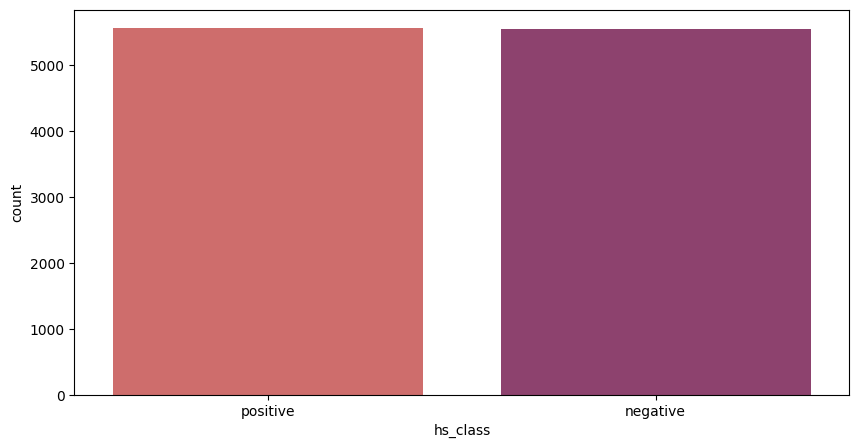

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='hs_class',data=data_preprocessed, palette='flare')

In [ ]:
import plotly.graph_objs as go

# Assuming `temp` is a DataFrame containing the necessary data
labels = temp['hs_class']
values = temp['text']

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])

fig.update_layout(
    title={
        "text": "Pie Chart of Sentiment Distribution",
        "x": 0.5,   # Set the x-coordinate to 0.5 for center alignment
        "y": 0.9    # Set the y-coordinate to 0.9 for top position
    },
    showlegend=True
)

fig.show()


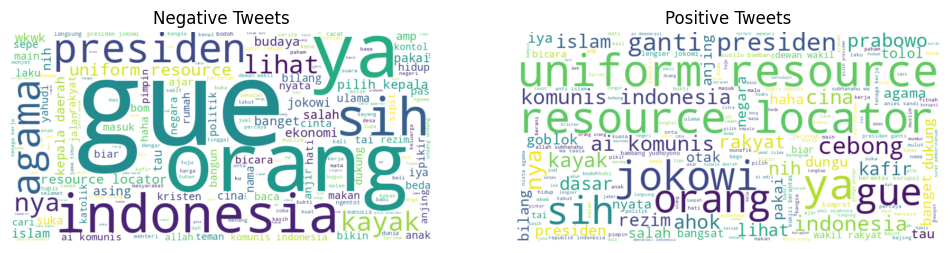

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter the DataFrame based on hs_class
neg_tweets = data_preprocessed[data_preprocessed['hs_class'] == 'negative']['text']
pos_tweets = data_preprocessed[data_preprocessed['hs_class'] == 'positive']['text']

# Concatenate the tweets into strings
neg_string = ' '.join(neg_tweets)
pos_string = ' '.join(pos_tweets)

# Generate word clouds if there are tweets available
if neg_string:
    wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(neg_string)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_neg, interpolation='bilinear')
    plt.title('Negative Tweets')
    plt.axis('off')

if pos_string:
    wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(pos_string)
    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_pos, interpolation='bilinear')
    plt.title('Positive Tweets')
    plt.axis('off')

plt.show()


In [ ]:
data_preprocessed.to_csv('data_preprocessed')

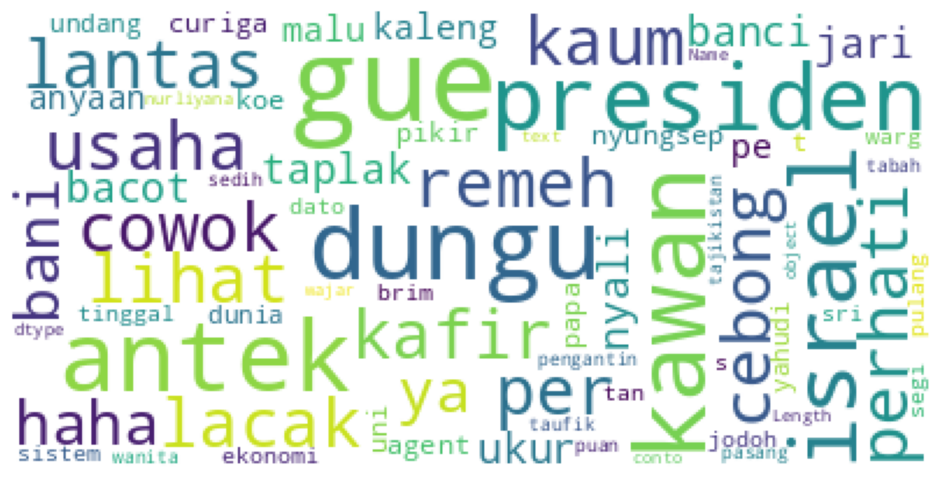

In [ ]:
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS
mpl.rcParams['figure.figsize']=(12.0,12.0)
mpl.rcParams['font.size']=12
mpl.rcParams['savefig.dpi']=100
mpl.rcParams['figure.subplot.bottom']=.1


stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=id_stopword_dict,
                          max_words=400,
                          max_font_size=50,
                          random_state=69
                         ).generate(str(data_preprocessed['text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

# **Split Data**

In [ ]:
# preprocess the data
df = data

# Separate features (text) and labels (hs_class)
X = df['text']
y = df['hs_class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the mapping dictionary
label_mapping = {'positive': 1, 'negative': 0}

# Apply the mapping to training and testing labels
y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)

# Save the labeled training and testing data to separate CSV files
train_data = pd.concat([X_train, y_train], axis=1)
train_data.to_csv('train_data.csv', index=False)

test_data = pd.concat([X_test, y_test], axis=1)
test_data.to_csv('test_data.csv', index=False)

print('Jumlah data training: ', len(X_train))
print('Jumlah data test: ', len(X_test))

Jumlah data training:  9218
Jumlah data test:  3951


In [ ]:
from sklearn.model_selection import train_test_split

# Check data consistency
if len(X) != len(y):
    raise ValueError("Data cardinality is ambiguous: x sizes = {}, y sizes = {}".format(len(x), len(y)))

# Perform data splitting with consistent shuffling
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Ensure the splitting maintains alignment between x and y

# Further preprocessing and model training...


In [ ]:
train_data

,text,hs_class
10650,pro yahudi,0
1224,bebas adil ustaz alfian tanjung langsung tangk...,1
6880,gilasih kimia organik kemarin gue modal gambar...,1
4454,seyogyanya benci ilfeel keparat otak sumbu pen...,1
2592,ulama waris nabi tegak data ilmu tsiqoh pe al ...,0
...,...,...
11964,foto foto loba tari sekolah dasar lks lomba te...,0
5191,rupiah haneul sok mes cupu entot on retweet,1
5390,a orang enak ajak curhat setia romantis,0
860,ayu mubah sedekah bumi lempar lemang info buda...,0


In [ ]:
test_data

,text,hs_class
4847,usir duta myanmar negeri kasih umat buddha taw...,1
6178,ancam bom mata sipit lucu lucu ya lucu lucu,1
4894,pria belanda mualaf jalan islam nusantara nu e...,0
5790,jancuk jancuk,0
11539,eh nurul kuliah jurus bahasa mandarin bera i k...,0
...,...,...
10920,eks zaman rejim najib,0
3708,agama percaya orang peluk agama a masuk surga ...,0
11050,prabowo bantu rohingya ri segani uniform resou...,1
7017,jilat muslim agama hina amp nista sih ahok can...,1
